[[483.34894   0.      423.66397]
 [  0.      492.56973 118.00166]
 [  0.        0.        1.     ]]
(256, 832, 9)


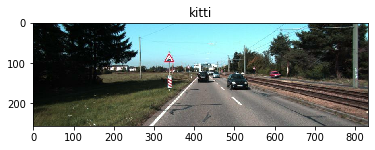

[[483.34894   0.      423.66397]
 [  0.      492.56973 118.00166]
 [  0.        0.        1.     ]]
(256, 832, 9)


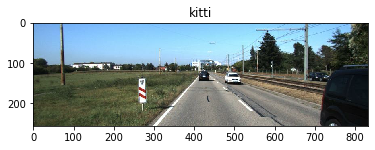

[[483.34894   0.      423.66397]
 [  0.      492.56973 118.00166]
 [  0.        0.        1.     ]]
(256, 832, 9)


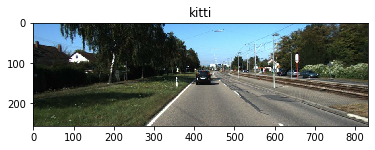

[[483.34894   0.      408.33603]
 [  0.      492.56973 118.00166]
 [  0.        0.        1.     ]]
(256, 832, 9)


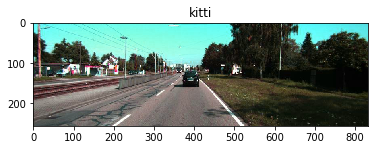

[[483.34894   0.      408.33603]
 [  0.      492.56973 118.00166]
 [  0.        0.        1.     ]]
(256, 832, 9)


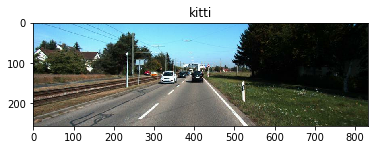

In [6]:
from __future__ import division
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

class DataLoader():
    def __init__(self, 
                 mode,
                 dataset_dir, 
                 img_height, 
                 img_width, 
                 num_source=2, 
                 num_threads=32,
                 batch_size=4, 
                 num_scales=4, 
                 ext='jpg',
                 random_color=True, 
                 random_scale_crop=True, 
                 shuffle=True):
        self.mode = mode
        self.dataset_dir = dataset_dir
        self.img_height = img_height
        self.img_width = img_width
        self.num_source = num_source
        self.seq_length = num_source + 1
        self.num_threads = num_threads
        self.batch_size = batch_size
        self.num_scales = num_scales
        self.file_extension = ext
        self.random_color = random_color
        self.random_scale_crop = random_scale_crop
        self.shuffle = shuffle
        
        self.split = 'val' # 'train', 'val': Dataset切的集合
        self.feature_description = { # 定义Feature结构，告诉解码器每个Feature的类型是什么
            'image': tf.io.FixedLenFeature([], tf.string),
            'cam': tf.io.FixedLenFeature([], tf.string),
        }
        self.flipping_mode = 'random' # 'always', 'random', 'none'
        self.random_color = True
        self.random_scale_crop = False
#         self.imagenet_norm = imagenet_norm
        
        #第一次執行 建立 TFRecord
#         self.write2TFRecord(self.dataset_dir, 'train', self.file_extension)
#         self.write2TFRecord(self.dataset_dir, 'val', self.file_extension)
        

    
    def build_dataloader(self):
        tfrecord_file = self.dataset_dir + '/%s.tfrecords' % self.split
        raw_dataset = tf.data.TFRecordDataset(tfrecord_file)    # 读取 TFRecord 文件
        
        
        dataset = raw_dataset.map(self._parse_example)
        
        if self.mode == "train_flow":
            dataset = dataset.map(self.preprocess_image)
            dataset = dataset.map(self.unpack_images)
            
            
        elif self.mode == "train_dp":
            dataset = dataset.map(self.preprocess_image)
            if self.random_color:
                dataset = dataset.map(self.augment_image_colorspace)
            dataset = dataset.map(self.unpack_images)

            if self.flipping_mode != 'none':
                if self.flipping_mode == 'random':
                    dataset = dataset.map(self.random_flip)

                elif self.flipping_mode == 'always':
                    dataset = dataset.map(self.flip)

            if self.random_scale_crop:
                dataset = dataset.map(self.augment_images_scale_crop)

        return dataset




    
    def format_file_list(self, data_root, split, ext):
        with open(data_root + '/%s.txt' % split, 'r') as f:
            frames = f.readlines()
        subfolders = [x.split(' ')[0] for x in frames]
        frame_ids = [x.split(' ')[1][:-1] for x in frames]
        image_file_list = [os.path.join(data_root, subfolders[i],
            frame_ids[i] + '.' + ext) for i in range(len(frames))]
        cam_file_list = [os.path.join(data_root, subfolders[i],
            frame_ids[i] + '_cam.txt') for i in range(len(frames))]

        all_list = {}
        all_list['image_file_list'] = image_file_list
        all_list['cam_file_list'] = cam_file_list
        return all_list
    
    def write2TFRecord(self, data_root, split, ext):
        file_list = self.format_file_list(data_root, split, ext)
        tfrecord_file = data_root + '/%s.tfrecords' % split
        with tf.io.TFRecordWriter(tfrecord_file) as writer:
            for filename, filename_cam in zip(file_list['image_file_list'], file_list['cam_file_list']):
                image = open(filename, 'rb').read()     # 读取数据集图片到内存，image 为一个 Byte 类型的字符串
                cam = open(filename_cam, 'rb').read()     # 读取数据集图片到内存，image 为一个 Byte 类型的字符串
                feature = {                             # 建立 tf.train.Feature 字典
                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),  # 图片是一个 Bytes 对象
                    'cam': tf.train.Feature(bytes_list=tf.train.BytesList(value=[cam]))   # 标签是一个 Int 对象
                }
                example = tf.train.Example(features=tf.train.Features(feature=feature)) # 通过字典建立 Example
                writer.write(example.SerializeToString())   # 将Example序列化并写入 TFRecord 文件
                
    def _parse_example(self, example_string): # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
        feature_dict = tf.io.parse_single_example(example_string, self.feature_description)
        feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])    # 解码JPEG图片
        rec_def = []
        for i in range(9):
            rec_def.append([1.0])
        raw_cam_vec = tf.io.decode_csv(records=feature_dict['cam'], record_defaults=rec_def)
        raw_cam_vec = tf.stack(raw_cam_vec)
        feature_dict['cam'] = tf.reshape(raw_cam_vec, [3, 3])

        return feature_dict['image'], feature_dict['cam']

    def preprocess_image(self, image, cam):
        # Convert from uint8 to float.
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        return image, cam

    def augment_image_colorspace(self, image_stack, cam):
        """Apply data augmentation to inputs."""
        image_stack_aug = image_stack
        # Randomly shift brightness.
        apply_brightness = tf.less(tf.random.uniform(
            shape=[], minval=0.0, maxval=1.0, dtype=tf.float32), 0.5)
        image_stack_aug = tf.cond(
            pred=apply_brightness,
            true_fn=lambda: tf.image.random_brightness(image_stack_aug, max_delta=0.1),
            false_fn=lambda: image_stack_aug)

        # Randomly shift contrast.
        apply_contrast = tf.less(tf.random.uniform(
            shape=[], minval=0.0, maxval=1.0, dtype=tf.float32), 0.5)
        image_stack_aug = tf.cond(
            pred=apply_contrast,
            true_fn=lambda: tf.image.random_contrast(image_stack_aug, 0.85, 1.15),
            false_fn=lambda: image_stack_aug)

        # Randomly change saturation.
        apply_saturation = tf.less(tf.random.uniform(
            shape=[], minval=0.0, maxval=1.0, dtype=tf.float32), 0.5)
        image_stack_aug = tf.cond(
            pred=apply_saturation,
            true_fn=lambda: tf.image.random_saturation(image_stack_aug, 0.85, 1.15),
            false_fn=lambda: image_stack_aug)

        # Randomly change hue.
        apply_hue = tf.less(tf.random.uniform(
            shape=[], minval=0.0, maxval=1.0, dtype=tf.float32), 0.5)
        image_stack_aug = tf.cond(
            pred=apply_hue,
            true_fn=lambda: tf.image.random_hue(image_stack_aug, max_delta=0.1),
            false_fn=lambda: image_stack_aug)

        image_stack_aug = tf.clip_by_value(image_stack_aug, 0, 1)
        return image_stack_aug, cam

    def unpack_images(self, image_seq, cam):
        """[h, w * seq_length, 3] -> [h, w, 3 * seq_length]."""
        image_list = [
            image_seq[:, i * self.img_width:(i + 1) * self.img_width, :]
            for i in range(self.seq_length)
        ]
        image_stack = tf.concat(image_list, axis=2)
        image_stack.set_shape([self.img_height, self.img_width, self.seq_length * 3])
        
        return image_stack

    def flip(self, image_stack, intrinsics):
        _, in_w, _ = image_stack.get_shape().as_list()
        fx = intrinsics[0, 0]
        fy = intrinsics[1, 1]
        cx = in_w - intrinsics[0, 2]
        cy = intrinsics[1, 2]
        intrinsics = self.make_intrinsics_matrix(fx, fy, cx, cy)
        return tf.image.flip_left_right(image_stack), intrinsics

    def random_flip(self, image_stack, intrinsics):
        prob = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)
        predicate = tf.less(prob, 0.5)
        return tf.cond(pred=predicate,
                       true_fn=lambda: self.flip(image_stack, intrinsics),
                       false_fn=lambda: (image_stack, intrinsics))

    def make_intrinsics_matrix(self, fx, fy, cx, cy):
        r1 = tf.stack([fx, 0, cx])
        r2 = tf.stack([0, fy, cy])
        r3 = tf.constant([0., 0., 1.])
        intrinsics = tf.stack([r1, r2, r3])
        return intrinsics

    def augment_images_scale_crop(self, im, intrinsics):
        """Randomly scales and crops image."""

        def scale_randomly(im, intrinsics):
            """Scales image and adjust intrinsics accordingly."""
            in_h, in_w, _ = im.get_shape().as_list()
            scaling = tf.random.uniform([2], 1, 1.2)
            x_scaling = scaling[0]
            y_scaling = scaling[1]
            out_h = tf.cast(in_h * y_scaling, dtype=tf.int32)
            out_w = tf.cast(in_w * x_scaling, dtype=tf.int32)
            # Add batch.
            im = tf.expand_dims(im, 0)
            im = tf.image.resize(im, [out_h, out_w], method=tf.image.ResizeMethod.AREA)
            im = im[0]
            fx = intrinsics[0, 0] * x_scaling
            fy = intrinsics[1, 1] * y_scaling
            cx = intrinsics[0, 2] * x_scaling
            cy = intrinsics[1, 2] * y_scaling
            intrinsics = self.make_intrinsics_matrix(fx, fy, cx, cy)
            return im, intrinsics

        # Random cropping
        def crop_randomly(im, intrinsics, out_h=256, out_w=832):
            """Crops image and adjust intrinsics accordingly."""
            # batch_size, in_h, in_w, _ = im.get_shape().as_list()
            in_h, in_w, _ = tf.unstack(tf.shape(input=im))
            offset_y = tf.random.uniform([1], 0, in_h - out_h + 1, dtype=tf.int32)[0]
            offset_x = tf.random.uniform([1], 0, in_w - out_w + 1, dtype=tf.int32)[0]
            im = tf.image.crop_to_bounding_box(im, offset_y, offset_x, out_h, out_w)
            fx = intrinsics[0, 0]
            fy = intrinsics[1, 1]
            cx = intrinsics[0, 2] - tf.cast(offset_x, dtype=tf.float32)
            cy = intrinsics[1, 2] - tf.cast(offset_y, dtype=tf.float32)
            intrinsics = self.make_intrinsics_matrix(fx, fy, cx, cy)
            return im, intrinsics

        im, intrinsics = scale_randomly(im, intrinsics)
        im, intrinsics = crop_randomly(im, intrinsics, out_h=self.img_height, out_w=self.img_width)
        return im, intrinsics
    
if __name__ == '__main__':
    dataloader = DataLoader(mode="train_dp", 
                        dataset_dir="../../../../datasets/kitti_3frames_256_832", 
                        img_height=256, 
                        img_width=832)
    dataset = dataloader.build_dataloader()
    
    for image, cam in dataset.take(5):
        print(cam.numpy())
        print(image.shape)
        plt.title('kitti')
        plt.imshow(image[:, :, :3].numpy())
        plt.show()